In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
# Titanic dataset (public mirror)
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

# Target
y = df["Survived"].astype(int)

# Features (keep common usable columns)
feature_cols = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
X = df[feature_cols].copy()

# Identify columns
numeric_cols = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
categorical_cols = ["Sex", "Embarked"]

# Preprocess: Impute + OneHot + Scale numeric (useful for NB/ANN/DBSCAN)
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("cat", categorical_pipe, categorical_cols)
    ],
    remainder="drop"
)

# Train-test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Titanic loaded:", df.shape)
print("Train:", X_tr.shape, "Test:", X_te.shape)


Titanic loaded: (891, 12)
Train: (668, 7) Test: (223, 7)


In [3]:
from sklearn.naive_bayes import GaussianNB

nb_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", GaussianNB())
])

nb_model.fit(X_tr, y_tr)
nb_pred = nb_model.predict(X_te)

print("=== Naive Bayes (Titanic) ===")
print("Accuracy:", accuracy_score(y_te, nb_pred))
print("\nReport:\n", classification_report(y_te, nb_pred, target_names=["Died","Survived"], zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_te, nb_pred))


=== Naive Bayes (Titanic) ===
Accuracy: 0.7802690582959642

Report:
               precision    recall  f1-score   support

        Died       0.82      0.82      0.82       137
    Survived       0.72      0.71      0.71        86

    accuracy                           0.78       223
   macro avg       0.77      0.77      0.77       223
weighted avg       0.78      0.78      0.78       223

Confusion Matrix:
 [[113  24]
 [ 25  61]]


In [4]:
from sklearn.tree import DecisionTreeClassifier

dt_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(
        criterion="entropy",
        max_depth=6,            # prevents overfitting
        min_samples_leaf=8,
        random_state=42
    ))
])

dt_model.fit(X_tr, y_tr)
dt_pred = dt_model.predict(X_te)

print("=== Decision Tree (Entropy) (Titanic) ===")
print("Accuracy:", accuracy_score(y_te, dt_pred))
print("\nReport:\n", classification_report(y_te, dt_pred, target_names=["Died","Survived"], zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_te, dt_pred))


=== Decision Tree (Entropy) (Titanic) ===
Accuracy: 0.7757847533632287

Report:
               precision    recall  f1-score   support

        Died       0.77      0.91      0.83       137
    Survived       0.79      0.57      0.66        86

    accuracy                           0.78       223
   macro avg       0.78      0.74      0.75       223
weighted avg       0.78      0.78      0.77       223

Confusion Matrix:
 [[124  13]
 [ 37  49]]


In [5]:
from sklearn.neural_network import MLPClassifier

ann_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation="relu",
        max_iter=500,
        random_state=42
    ))
])

ann_model.fit(X_tr, y_tr)
ann_pred = ann_model.predict(X_te)

print("=== ANN (MLP) (Titanic) ===")
print("Accuracy:", accuracy_score(y_te, ann_pred))
print("\nReport:\n", classification_report(y_te, ann_pred, target_names=["Died","Survived"], zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_te, ann_pred))


=== ANN (MLP) (Titanic) ===
Accuracy: 0.7937219730941704

Report:
               precision    recall  f1-score   support

        Died       0.81      0.87      0.84       137
    Survived       0.76      0.67      0.72        86

    accuracy                           0.79       223
   macro avg       0.79      0.77      0.78       223
weighted avg       0.79      0.79      0.79       223

Confusion Matrix:
 [[119  18]
 [ 28  58]]


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


=== Linear Regression (Titanic) ===
Accuracy (after threshold 0.5): 0.7937219730941704
Mean Squared Error: 0.15417922320727076
R² Score: 0.3492464275272138


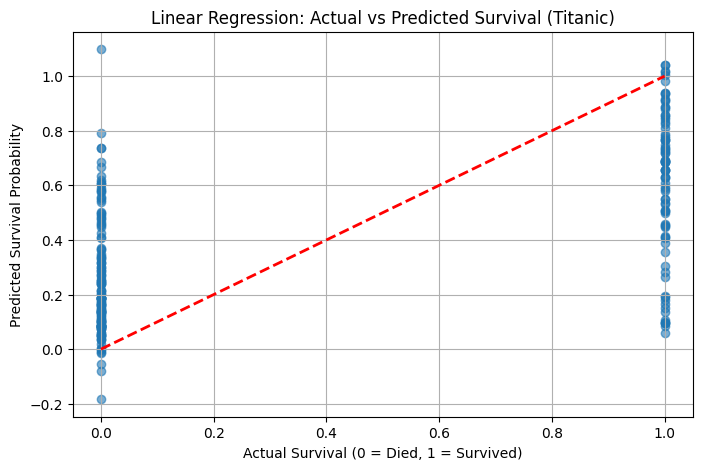

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# -------- Train Linear Regression --------
lr_model = Pipeline(steps=[
    ("prep", preprocess),
    ("reg", LinearRegression())
])

lr_model.fit(X_tr, y_tr)

# Continuous predictions
y_cont = lr_model.predict(X_te)

# Convert to binary classes using threshold
y_lr_pred = (y_cont >= 0.5).astype(int)

# -------- Metrics --------
accuracy = accuracy_score(y_te, y_lr_pred)
mse = mean_squared_error(y_te, y_cont)
r2 = r2_score(y_te, y_cont)

print("=== Linear Regression (Titanic) ===")
print("Accuracy (after threshold 0.5):", accuracy)
print("Mean Squared Error:", mse)
print("R² Score:", r2)

plt.figure(figsize=(8, 5))

plt.scatter(
    y_te,
    y_cont,
    alpha=0.6
)

# Ideal prediction line
plt.plot([0, 1], [0, 1], color="red", linestyle="--", linewidth=2)

plt.xlabel("Actual Survival (0 = Died, 1 = Survived)")
plt.ylabel("Predicted Survival Probability")
plt.title("Linear Regression: Actual vs Predicted Survival (Titanic)")

plt.grid(True)
plt.show()


In [12]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

# Build processed numeric feature matrix
X_all = preprocess.fit_transform(X)
X_all_dense = X_all.toarray() if hasattr(X_all, "toarray") else X_all

# 2D projection for plotting
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_all_dense)

print("Processed matrix:", X_all_dense.shape)
print("2D plot matrix:", X_2d.shape)


Processed matrix: (891, 10)
2D plot matrix: (891, 2)


=== KMeans ===
Cluster counts: [645 246]
Silhouette Score: 0.3046469297380089


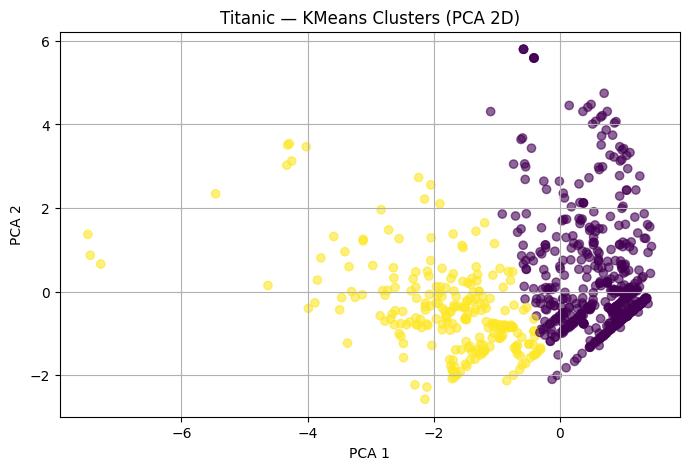


Survival rate by KMeans cluster:
 kmeans_cluster
0    0.302326
1    0.597561
Name: Survived, dtype: float64


In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
k_labels = kmeans.fit_predict(X_all_dense)

print("=== KMeans ===")
print("Cluster counts:", np.bincount(k_labels))
print("Silhouette Score:", silhouette_score(X_all_dense, k_labels))

# Plot clusters in PCA 2D
plt.figure(figsize=(8,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=k_labels, alpha=0.6)
plt.title("Titanic — KMeans Clusters (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

# Optional: survival rate per cluster
df_k = df.copy()
df_k["kmeans_cluster"] = k_labels
print("\nSurvival rate by KMeans cluster:\n", df_k.groupby("kmeans_cluster")["Survived"].mean())


=== DBSCAN ===
Labels (−1 is noise): {np.int64(-1): np.int64(264), np.int64(0): np.int64(368), np.int64(1): np.int64(23), np.int64(2): np.int64(81), np.int64(3): np.int64(20), np.int64(4): np.int64(32), np.int64(5): np.int64(31), np.int64(6): np.int64(39), np.int64(7): np.int64(20), np.int64(8): np.int64(13)}


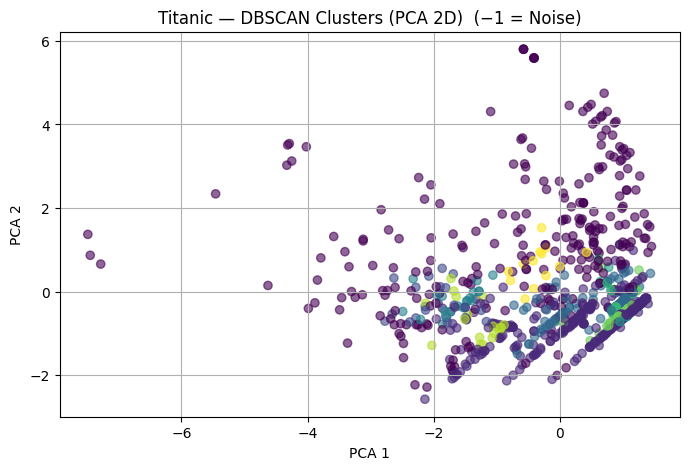


Survival rate by DBSCAN cluster (excluding noise):
 dbscan_cluster
0    0.152174
1    1.000000
2    0.629630
3    1.000000
4    0.093750
5    0.806452
6    0.179487
7    0.400000
8    0.846154
Name: Survived, dtype: float64


In [14]:
from sklearn.cluster import DBSCAN

# eps depends on data scaling; after StandardScaler, try around 0.8–1.5
db = DBSCAN(eps=1.2, min_samples=10)
db_labels = db.fit_predict(X_all_dense)

unique, counts = np.unique(db_labels, return_counts=True)
print("=== DBSCAN ===")
print("Labels (−1 is noise):", dict(zip(unique, counts)))

# Plot DBSCAN clusters in PCA 2D
plt.figure(figsize=(8,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=db_labels, alpha=0.6)
plt.title("Titanic — DBSCAN Clusters (PCA 2D)  (−1 = Noise)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

# Optional: survival rate per cluster (exclude noise)
df_d = df.copy()
df_d["dbscan_cluster"] = db_labels
valid = df_d["dbscan_cluster"] != -1
if valid.sum() > 0:
    print("\nSurvival rate by DBSCAN cluster (excluding noise):\n",
          df_d[valid].groupby("dbscan_cluster")["Survived"].mean())
else:
    print("\nDBSCAN produced only noise. Try changing eps (e.g., 0.8 or 1.5).")


In [15]:
import numpy as np

def train_som(X, grid=(10, 10), lr=0.4, sigma=3.0, epochs=8, random_state=42):
    rng = np.random.default_rng(random_state)
    n_samples, n_features = X.shape
    gx, gy = grid

    # Initialize weights
    W = rng.normal(0, 1, size=(gx, gy, n_features))

    # Grid coordinates
    coords = np.array([(i, j) for i in range(gx) for j in range(gy)]).reshape(gx, gy, 2)

    for epoch in range(epochs):
        idx = rng.permutation(n_samples)
        for i in idx:
            x = X[i]

            # BMU (best matching unit)
            dists = np.linalg.norm(W - x, axis=2)
            bmu = np.unravel_index(np.argmin(dists), (gx, gy))

            # decay
            lr_t = lr * (1 - epoch / epochs)
            sigma_t = sigma * (1 - epoch / epochs)
            if sigma_t < 1e-6:
                sigma_t = 1e-6

            # neighborhood function
            bmu_coord = np.array(bmu)
            dist_grid = np.linalg.norm(coords - bmu_coord, axis=2)
            h = np.exp(-(dist_grid**2) / (2 * sigma_t**2))

            # update
            W += lr_t * h[..., None] * (x - W)

    return W

def som_cell_indices(X, W):
    gx, gy, _ = W.shape
    cells = np.zeros(X.shape[0], dtype=int)
    for i, x in enumerate(X):
        dists = np.linalg.norm(W - x, axis=2)
        bmu = np.unravel_index(np.argmin(dists), (gx, gy))
        cells[i] = bmu[0] * gy + bmu[1]
    return cells

# Train SOM on processed features
grid = (10, 10)
W = train_som(X_all_dense, grid=grid, lr=0.4, sigma=3.0, epochs=8, random_state=42)
som_cells = som_cell_indices(X_all_dense, W)

print("SOM cells used:", len(np.unique(som_cells)))


SOM cells used: 80


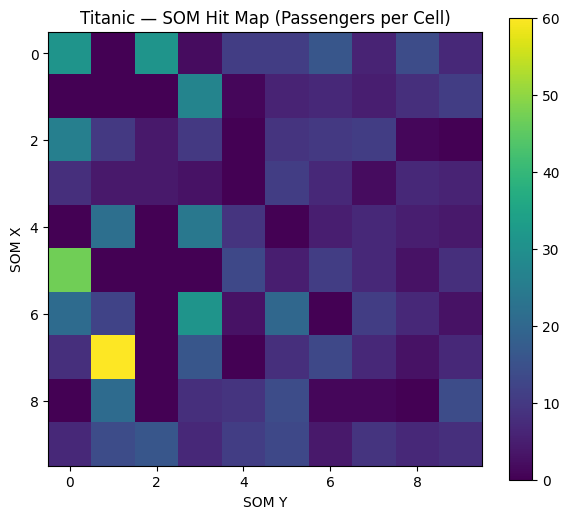

In [16]:
gx, gy = grid
hit_map = np.zeros((gx, gy), dtype=int)

for c in som_cells:
    hit_map[c // gy, c % gy] += 1

plt.figure(figsize=(7,6))
plt.imshow(hit_map)
plt.title("Titanic — SOM Hit Map (Passengers per Cell)")
plt.xlabel("SOM Y")
plt.ylabel("SOM X")
plt.colorbar()
plt.show()
